![lop](../../images/logo_diive1_128px.png)

<span style='font-size:32px; display:block;'>
<b>
    Outlier detection: absolute limits
</b>
</span>

---
**Notebook version**: `1` (22 Apr 2024)  
**Author**: Lukas Hörtnagl (holukas@ethz.ch)  

</br>

# **Description**

- Flag values in time series that are outside specified absolute limits
- Limits for daytime and nighttime data are given separately
- Flag contains `0` and `2`, whereby `0=OK` and `2=outlier`
- This example uses air temperature for one month and adds impulse noise to add some spikes to the data before testing

</br>

# **Imports**

In [1]:
import importlib.metadata
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import pandas as pd

warnings.filterwarnings('ignore')

import diive.configs.exampledata as ed
from diive.core.plotting.timeseries import TimeSeries
from diive.pkgs.createvar.noise import add_impulse_noise
from diive.pkgs.outlierdetection.absolutelimits import AbsoluteLimitsDaytimeNighttime

version_diive = importlib.metadata.version("diive")
print(f"diive version: v{version_diive}")

diive version: v0.79.0


</br>

# **Docstring**

In [2]:
help(AbsoluteLimitsDaytimeNighttime)

Help on function AbsoluteLimitsDaytimeNighttime in module diive.pkgs.outlierdetection.absolutelimits:

AbsoluteLimitsDaytimeNighttime(series: pandas.core.series.Series, lat: float, lon: float, utc_offset: int, daytime_minmax: list, nighttime_minmax: list, idstr: str = None, showplot: bool = False, verbose: bool = False)
    Generate flag that indicates if values in data are outside
    the specified range, defined by providing allowed minimum and
    maximum values, separately for daytime and nighttime data.



</br>

# **Load example data**

## Load and prepare data (one month)

In [3]:
df = ed.load_exampledata_parquet()
s = df['Tair_f'].copy()
s = s.loc[s.index.year == 2018].copy()
s = s.loc[s.index.month == 7].copy()
s

Loaded .parquet file F:\Sync\luhk_work\20 - CODING\21 - DIIVE\diive\diive\configs\exampledata\exampledata_PARQUET_CH-DAV_FP2022.5_2013-2022_ID20230206154316_30MIN.parquet (0.061 seconds). Detected time resolution of <30 * Minutes> / 30min 


TIMESTAMP_MIDDLE
2018-07-01 00:15:00    13.014
2018-07-01 00:45:00    12.409
2018-07-01 01:15:00    12.418
2018-07-01 01:45:00    12.071
2018-07-01 02:15:00    12.182
                        ...  
2018-07-31 21:45:00    16.928
2018-07-31 22:15:00    16.276
2018-07-31 22:45:00    16.256
2018-07-31 23:15:00    15.763
2018-07-31 23:45:00    15.919
Freq: 30min, Name: Tair_f, Length: 1488, dtype: float64

## Test data: add impulse noise to time series, this creates spike outliers

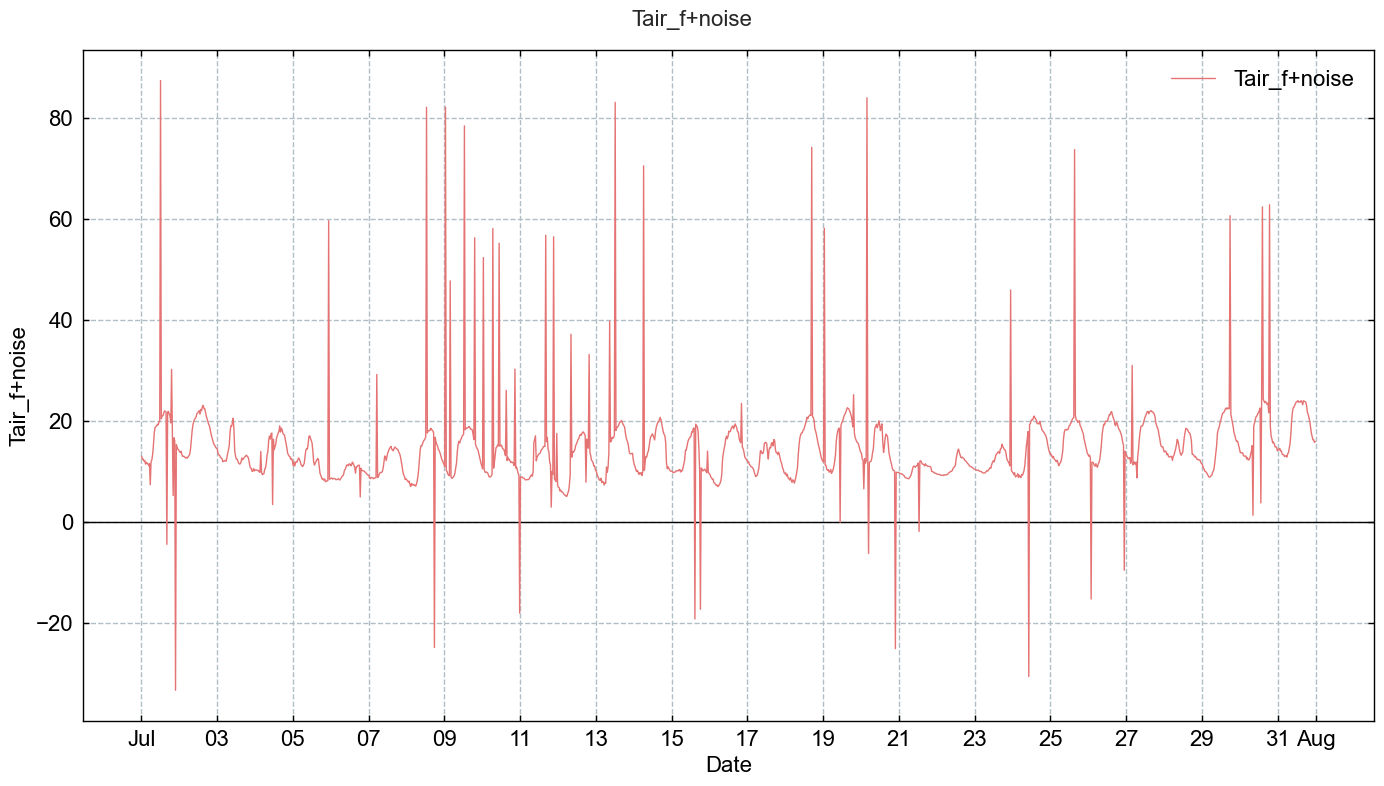

In [4]:
s_noise = add_impulse_noise(series=s,
                            factor_low=-10,
                            factor_high=3,
                            contamination=0.04)  # Add impulse noise (spikes)
s_noise.name = f"{s.name}+noise"
TimeSeries(s_noise).plot();

</br>

# **Absolute limits, separately for daytime and nighttime data**

## Calculate flag (0=OK, 2=outlier)

[AbsoluteLimitsDaytimeNighttime]  running AbsoluteLimitsDaytimeNighttime ...
Total found outliers: 33 values (daytime)
Total found outliers: 17 values (nighttime)
Total found outliers: 50 values (daytime+nighttime)


TIMESTAMP_MIDDLE
2018-07-01 00:15:00    0.0
2018-07-01 00:45:00    0.0
2018-07-01 01:15:00    0.0
2018-07-01 01:45:00    0.0
2018-07-01 02:15:00    0.0
                      ... 
2018-07-31 21:45:00    0.0
2018-07-31 22:15:00    0.0
2018-07-31 22:45:00    0.0
2018-07-31 23:15:00    0.0
2018-07-31 23:45:00    0.0
Freq: 30min, Name: FLAG_Tair_f+noise_OUTLIER_ABSLIM_DTNT_TEST, Length: 1488, dtype: float64

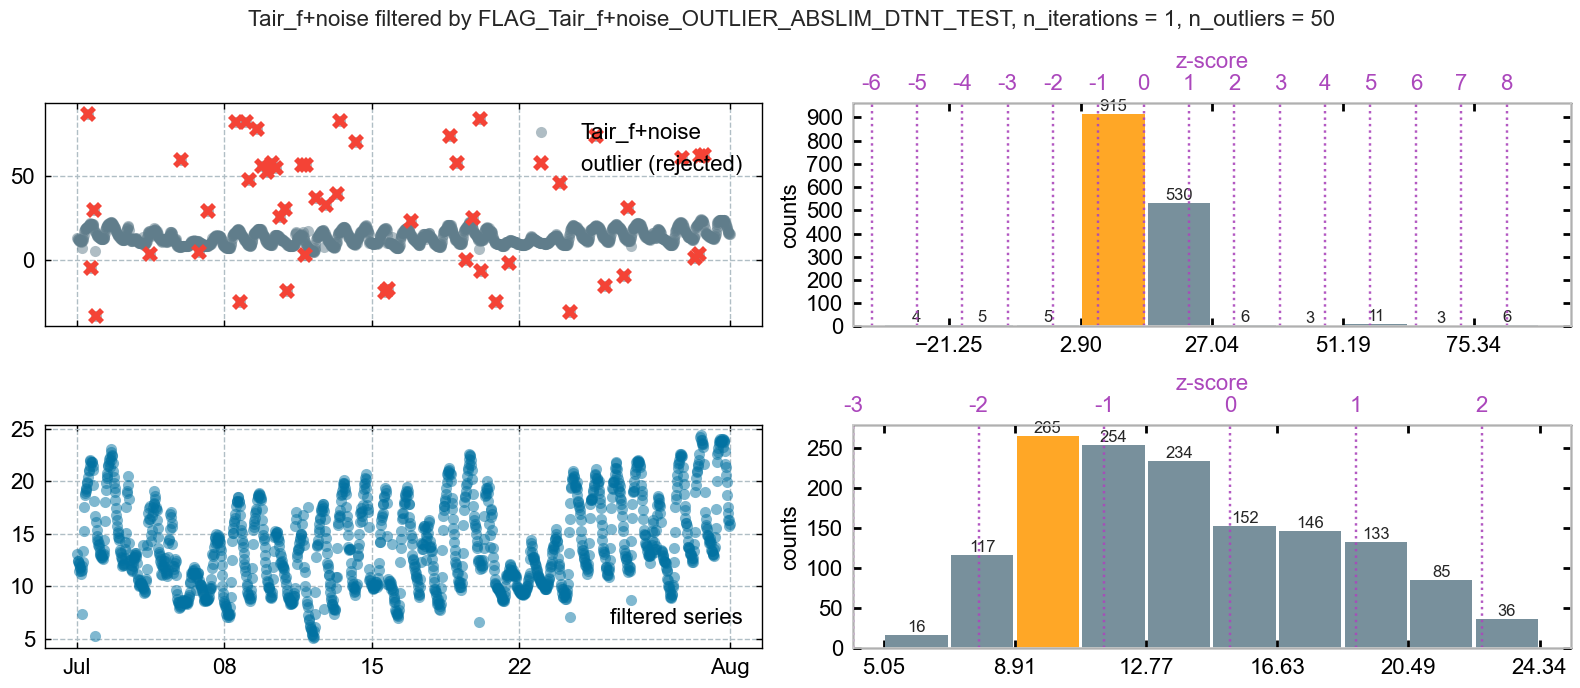

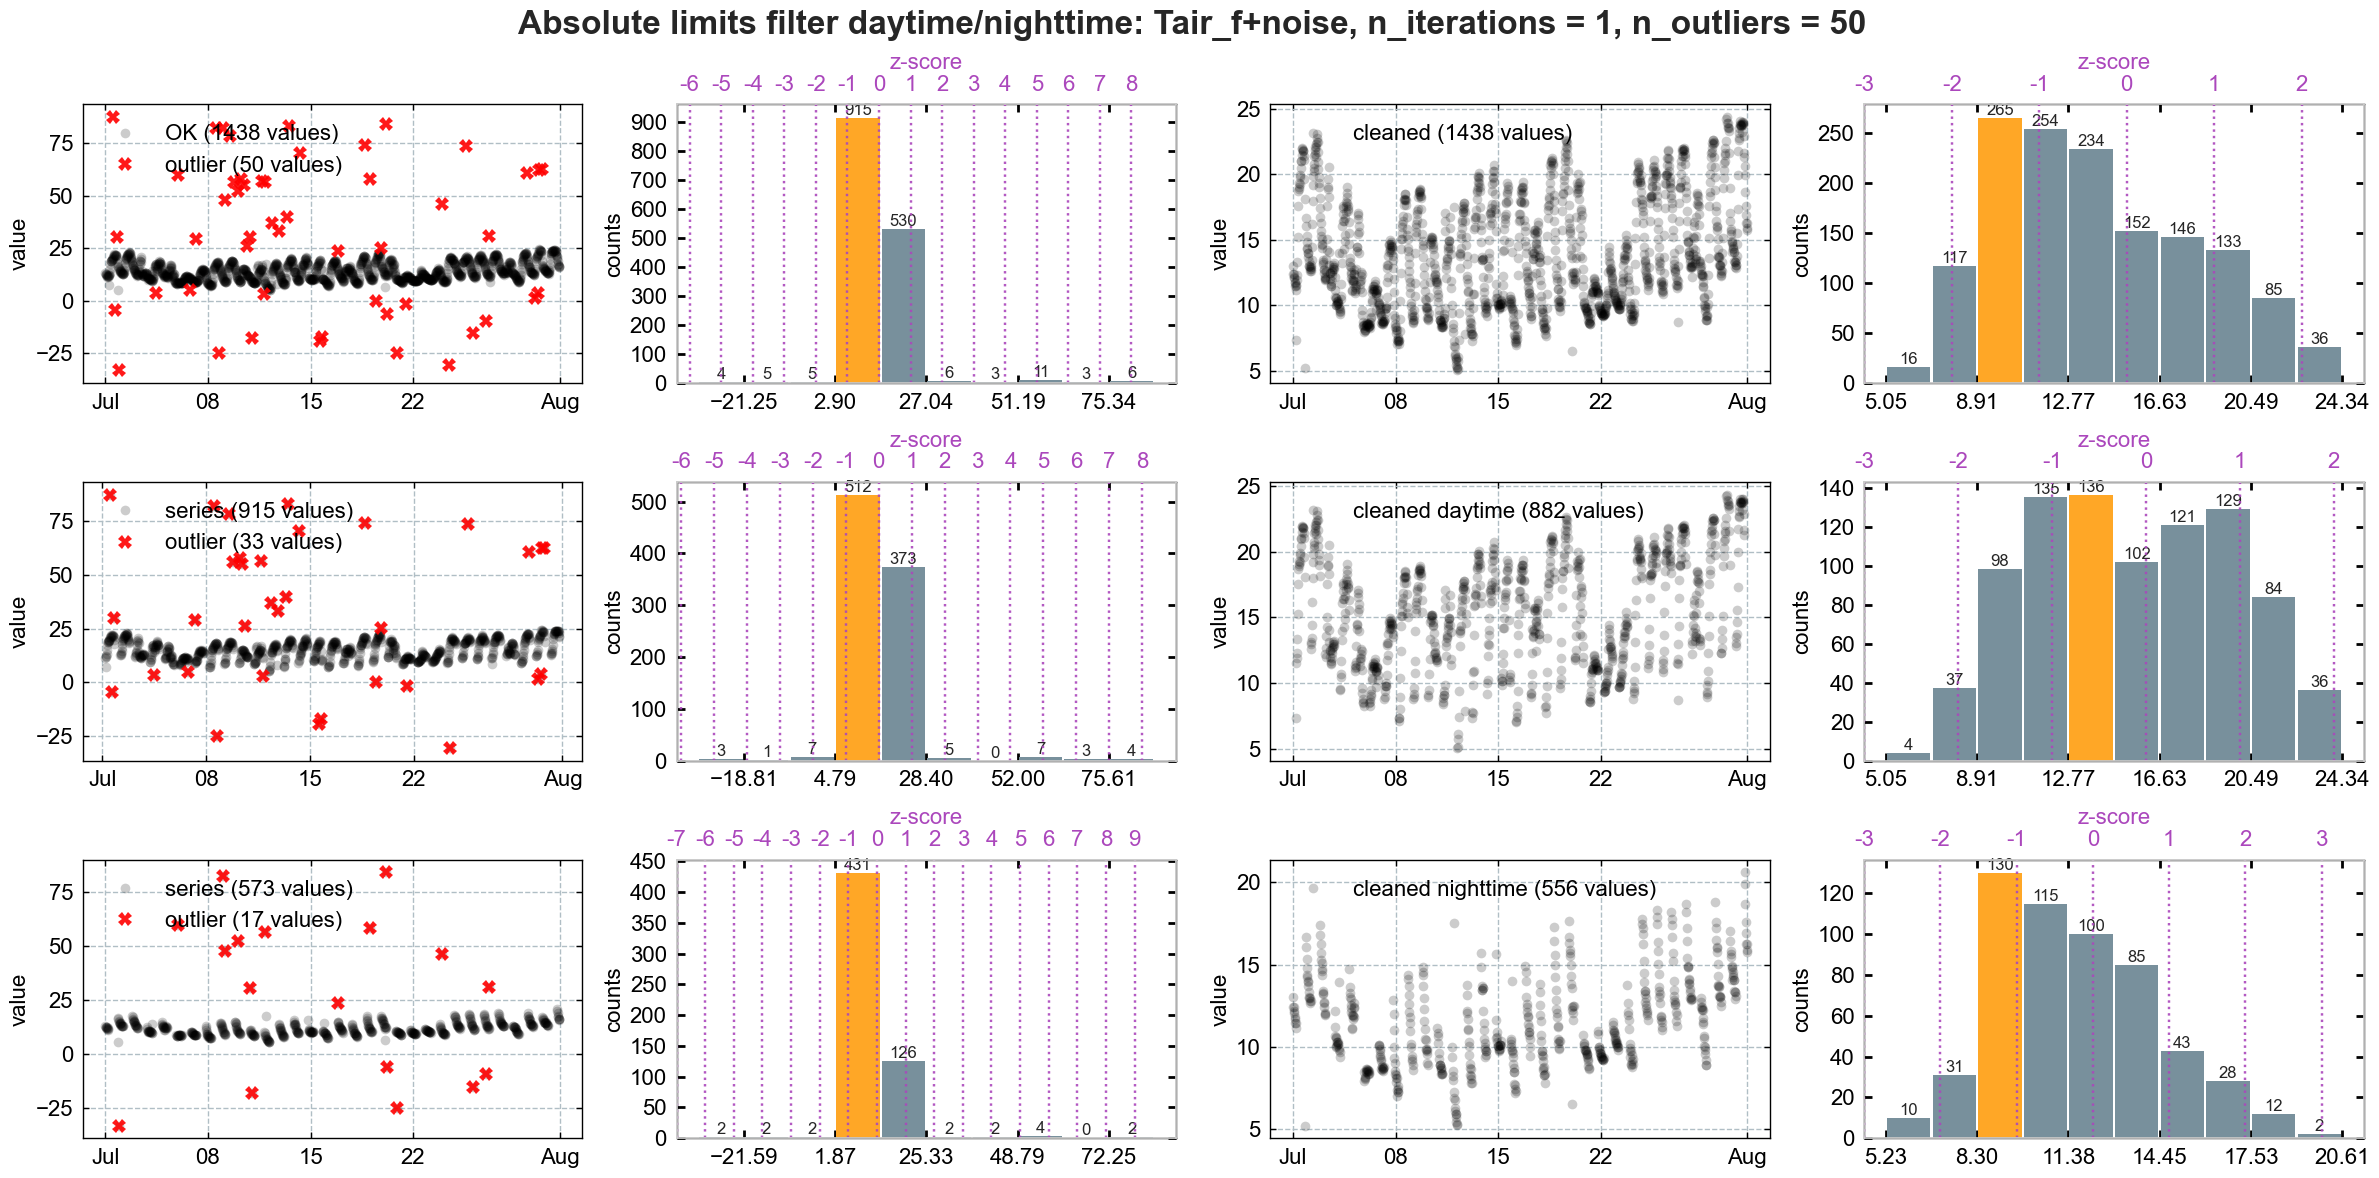

In [5]:
daytime_minmax = [5, 25.0]  # Allowed min/max values for daytime data
nighttime_minmax = [-1, 22]  # Allowed min/max values for nighttime data
al = AbsoluteLimitsDaytimeNighttime(
    series=s_noise,
    lat=46.815333,
    lon=9.855972,
    utc_offset=1,
    daytime_minmax=daytime_minmax,
    nighttime_minmax=nighttime_minmax,
    showplot=True,
    verbose=True
)
al.calc(repeat=False)
flag = al.get_flag()
flag

## Collect data
- Combine the original series, series+noise, outlier flag and two flags marking daytime or nighttime data in one dataframe for easier plotting
- It is possible to get the daytime/nighttime flag from the outlier detection class, but it is a bit hidden

In [6]:
frame = {'s': s, 's_noise': s_noise, 'flag': flag, 'is_daytime': al.is_daytime.astype(int),
         'is_nighttime': al.is_nighttime.astype(int)}
checkdf = pd.DataFrame.from_dict(frame)
checkdf

,s,s_noise,flag,is_daytime,is_nighttime
TIMESTAMP_MIDDLE,,,,,
2018-07-01 00:15:00,13.014,13.014,0.0,0,1
2018-07-01 00:45:00,12.409,12.409,0.0,0,1
2018-07-01 01:15:00,12.418,12.418,0.0,0,1
2018-07-01 01:45:00,12.071,12.071,0.0,0,1
2018-07-01 02:15:00,12.182,12.182,0.0,0,1
...,...,...,...,...,...
2018-07-31 21:45:00,16.928,16.928,0.0,0,1
2018-07-31 22:15:00,16.276,16.276,0.0,0,1
2018-07-31 22:45:00,16.256,16.256,0.0,0,1


## Plot

### Daytime

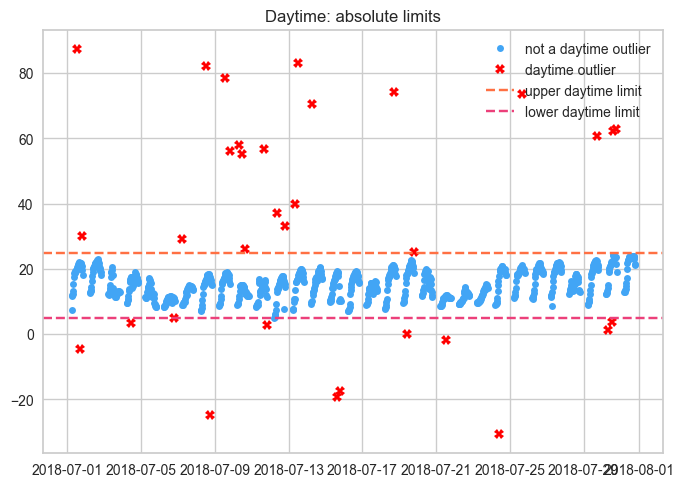

In [7]:
daytime_df = checkdf.loc[checkdf['is_daytime'] == 1].copy()
good_dt = daytime_df.loc[daytime_df['flag'] == 0]['s_noise']
bad_dt = daytime_df.loc[daytime_df['flag'] == 2]['s_noise']

fig, ax = plt.subplots()
ax.plot(good_dt, color="#42A5F5", label="not a daytime outlier", lw=0, ms=5, marker="o")
ax.plot(bad_dt, color="red", label="daytime outlier", lw=0, ms=7, marker="X")
ax.axhline(daytime_minmax[1], ls="--", color="#FF7043", label="upper daytime limit")
ax.axhline(daytime_minmax[0], ls="--", color="#EC407A", label="lower daytime limit")
plt.title("Daytime: absolute limits")
plt.legend()
plt.show()

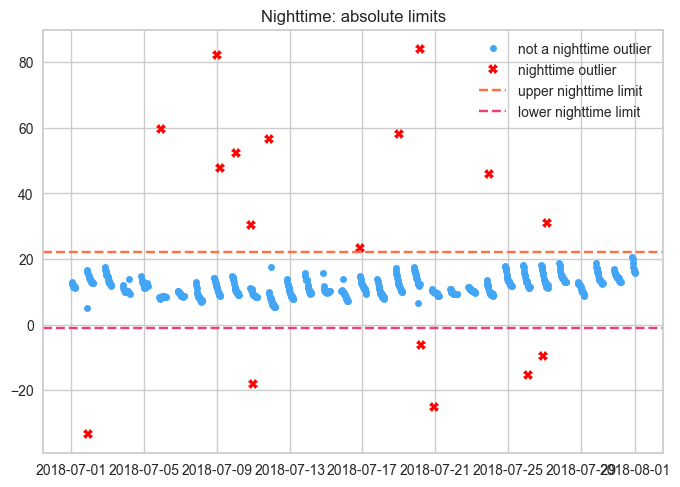

In [8]:
nighttime_df = checkdf.loc[checkdf['is_nighttime'] == 1].copy()
good_nt = nighttime_df.loc[nighttime_df['flag'] == 0]['s_noise']
bad_nt = nighttime_df.loc[nighttime_df['flag'] == 2]['s_noise']

fig, ax = plt.subplots()
ax.plot(good_nt, color="#42A5F5", label="not a nighttime outlier", lw=0, ms=5, marker="o")
ax.plot(bad_nt, color="red", label="nighttime outlier", lw=0, ms=7, marker="X")
ax.axhline(nighttime_minmax[1], ls="--", color="#FF7043", label="upper nighttime limit")
ax.axhline(nighttime_minmax[0], ls="--", color="#EC407A", label="lower nighttime limit")
plt.title("Nighttime: absolute limits")
plt.legend()
plt.show()

</br>

# End of notebook

In [9]:
dt_string = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
print(f"Finished {dt_string}")

Finished 2024-08-22 15:14:59
